# Evaluation Notebook

**Description**

This notebook uses the output from each method to evalute their output using F1, F1_CTP, Precision, Precision_CTP
You can access the output that we had for each method in this [DRIVE LINK](https://drive.google.com/file/d/1ns10fCc7Mz1W2wAvj39jbLxQmVyg8ufI/view?usp=sharing)

----

Author: João Phillipe Cardenuto\
Email: phillipe.cardenuto@ic.unicamp.br\
December, 2020
----


In this notebook we use the additional modules:\
prettytable\
`pip install prettytable`\
tqdm\
`pip install tqdm`\



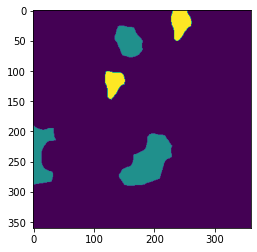

In [232]:
plt.imshow(Image.open("/work/jcardenuto/translate-forgery-algs/python-CMFD-adaptative-oversegmentation/python/results_new/simple/forgery/duplication/copy-move/random/00230/figure_forgery_final_map_ids.png"))

In [1]:
# Including path to forgery_lib dataset on the notebook
# LIB_PATH = "../"
# import sys
# sys.path.append(LIB_PATH)

from glob import glob
import cv2
import numpy as np
from prettytable import PrettyTable
import os 
from metrics import (F1, precision, F1_CTP, precision_CTP)
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
import pandas as pd

# Run Evaluation on the TESTSET - Simple Figures

### Duplication

In [2]:
def vole_evaluation(result, gt_pristine, gt_forgery):
    """
    Evaluates the output from the method Christlein et al. (2012) “An evaluation of popular
    copy-move forgery detection approaches". For this we use a modified version inside 
    the detection_method directory in this from this repository.
    
    """
    
    result = cv2.imread(result, cv2.IMREAD_GRAYSCALE)
    
    # Insert pristine regions and forgery regions in the same map
    gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
    gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
    a = np.unique(gt_pristine)
    a = a[a!=0]
    for i in a:
        gt_forgery[gt_pristine == i] = i
    
    f1 = F1(result,gt_forgery)
    f1_cc = 0 if f1==0 else F1_CTP(result,gt_forgery) # Optimize f1_cc to avoid check when f1 is 0
    p = precision(result,gt_forgery)
    p_cc = 0 if p==0 else precision_CTP(result,gt_forgery) # Optimize p_cc to avoid check when p is 0
    
    return f1, f1_cc ,p, p_cc


def patch_match_evaluation(result, gt_pristine, gt_forgery):
    """
    Evaluates the output from the method from Cozzolino et al. (2015) “Efficient dense-field 
    copy-move forgery detection”, from the implemented version of Ehret (2018), “Automatic detection of internal copy-move
    forgeries in images”. For this we use a modified version inside the detection_method directory in this from this repository.
    
    """
    
    gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
    gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
    result = np.fromfile(result,np.int32).reshape(gt_pristine.shape).astype("uint8")
    
    a = np.unique(gt_pristine)
    a = a[a!=0]
    for i in a:
        gt_forgery[gt_pristine == i] = i
    
    f1 = F1(result,gt_forgery)
    f1_cc = 0 if f1==0 else F1_CTP(result,gt_forgery) # Optimize f1_cc to avoid check when f1 is 0
    p = precision(result,gt_forgery)
    p_cc = 0 if p==0 else precision_CTP(result,gt_forgery) # Optimize p_cc to avoid check when p is 0
    
    return f1, f1_cc ,p, p_cc

def busternet_evaluation(result_path, gt_pristine, gt_forgery):
    """
    Evaluates the output from Wu et al. (2018) "Busternet: Detecting image copy-move forgery with source/target localization".
    To generate the ouput, we used the pre-trained model from https://github.com/isi-vista/BusterNet
    """
    
    result = cv2.imread(result_path)
    # Make the output of busternet as binary
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB).astype("uint8")
    output_format = np.zeros((result.shape[0],result.shape[1])).astype("uint8")
    # If the color of the output is RED or GREEN insert it on output_format
    output_format[ result[:,:,0] > 100] = 1
    output_format[ result[:,:,1] > 100] = 1
    result = output_format
    
    if 'pristine' in result_path:
        gt_forgery = np.zeros((result.shape[0],result.shape[1])).astype("uint8")
        
    else:     
        gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
        gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
        
        # Pre-process gt_forgery as the output of busternet
        gt_forgery [ gt_pristine > 0] = 1
        gt_forgery = cv2.resize(gt_forgery, (result.shape[1],result.shape[0]))
        gt_forgery[gt_forgery > 0] = 1
    
    f1 = F1(result,gt_forgery)
    f1_cc = 0 if f1==0 else F1_CTP(result,gt_forgery) # Optimize f1_cc to avoid check when f1 is 0
    p = precision(result,gt_forgery)
    p_cc = 0 if p==0 else precision_CTP(result,gt_forgery) # Optimize p_cc to avoid check when p is 0
    
    return f1, f1_cc ,p, p_cc

def overseg_evaluation(result_path, gt_pristine, gt_forgery):
    """
    Evaluates the output from Pun et al. (2015) "Image forgery detection using adaptive over-segmentation and feature points matching".
    We base our implementation in the Pun et al. article and in the MatLab code from the github user MohenseZandi
    """
    
    gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
    gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
    result = cv2.imread(result_path, cv2.IMREAD_GRAYSCALE)
    
    a = np.unique(gt_pristine)
    a = a[a!=0]
    for i in a:
        gt_forgery[gt_pristine == i] = i
    
    f1 = F1(result,gt_forgery)
    f1_cc = 0 if f1==0 else F1_CTP(result,gt_forgery) # Optimize f1_cc to avoid check when f1 is 0
    p = precision(result,gt_forgery)
    p_cc = 0 if p==0 else precision_CTP(result,gt_forgery) # Optimize p_cc to avoid check when p is 0
    
    return f1, f1_cc ,p, p_cc

def hfpm_evaluation (result_path, gt_pristine, gt_forgery):
    """
    Evaluates the output from Pun et al. (2015) "Fast and Effective Image Copy-Move Forgery Detection via Hierarchical Feature Point Matching".
    We base our implementation in the Yuanman et al. article and in the original Matlab code https://github.com/YuanmanLi/FE-CMFD-HFPM
    """
    
    gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
    gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
    result = cv2.imread(result_path, cv2.IMREAD_GRAYSCALE)
    
    a = np.unique(gt_pristine)
    a = a[a!=0]
    for i in a:
        gt_forgery[gt_pristine == i] = i
    
    f1 = F1(result,gt_forgery)
    f1_cc = 0 if f1==0 else F1_CTP(result,gt_forgery) # Optimize f1_cc to avoid check when f1 is 0
    p = precision(result,gt_forgery)
    p_cc = 0 if p==0 else precision_CTP(result,gt_forgery) # Optimize p_cc to avoid check when p is 0
    
    return f1, f1_cc ,p, p_cc

def check_output(detection_output, gt_forgery, gt_pristine, method):
    
    if not os.path.isfile(detection_output):
        return (0,0,0,0)
    
    if method == 'vole':
        return vole_evaluation(detection_output, gt_pristine, gt_forgery)
    elif method == 'pm': #patchmacth
        return patch_match_evaluation(detection_output, gt_pristine, gt_forgery)
    elif method == 'busternet':
        return busternet_evaluation (detection_output, gt_pristine, gt_forgery)
    elif method == 'overseg':
        return overseg_evaluation (detection_output, gt_pristine, gt_forgery)
    elif method == 'hfpm':
        return hfpm_evaluation (detection_output, gt_pristine, gt_forgery)
    
    return (0,0,0,0)
        

# Evaluating Copy-Move Simple Figures
Here we evaluate copy move images for duplication propose and for cleaning propose.

In a duplication forgery, an object is paste on the top of a background region

In a cleaning forgery, a background region is pasted on the top of a object (hidden the object).

-----
### Detection Methods
- SURF
- SIFT
- Zernike using PatchMatch
- Sift using PatchMatch

In [5]:
test_path = '/work/jcardenuto/translate-forgery-algs/tmp/'
test_simple_figures = glob(f'{test_path}testset/simple/forgery/cleaning/bf/**/annotations.json',recursive=True) + glob(f'{test_path}testset/simple/forgery/duplication/copy-move/**/annotations.json',recursive=True)
test_simple_figures = [t.replace(test_path,'') for t in test_simple_figures]

In [4]:
SIMPLE_EVAL = pd.DataFrame(columns=['F1','F1-Check','Precision','Precision-Check','Method', "Detection-Map"])

for test_figure in tqdm(test_simple_figures):
    gt_forgery = test_path + os.path.sep + os.path.dirname(test_figure) + os.path.sep + "figure_forgery_gt.png"
    gt_pristine = test_path + os.path.sep +  os.path.dirname(test_figure) + os.path.sep + "figure_pristine_gt.png"
    
    surf_vole = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "vole_surf_figure_forgery_labeled.png"
    sift_vole = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "vole_sift_figure_forgery_labeled.png"
    sift_pm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "fd_sift_figure_forgery.png.bin"
    zernike_pm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "fd_zernik_figure_forgery.png.bin"
    busternet = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "busternet_figure_forgery.png"
    overseg = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "overseg_figure_forgery_detection_map.png"
    hfpm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "hfpm_figure_forgery_detection_map.png"
    
    
    f1, f1_cc ,p, p_cc = check_output(surf_vole, gt_pristine, gt_forgery,'vole')
    SIMPLE_EVAL = SIMPLE_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SURF-VOLE', "Detection-Map": surf_vole}))
    
    f1, f1_cc ,p, p_cc = check_output(sift_vole, gt_pristine, gt_forgery,'vole')
    SIMPLE_EVAL = SIMPLE_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SIFT-VOLE', "Detection-Map": sift_vole}))
    
    f1, f1_cc ,p, p_cc = check_output(sift_pm, gt_pristine, gt_forgery,'pm')
    SIMPLE_EVAL = SIMPLE_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SIFT-PM', "Detection-Map": sift_pm}))
    
    f1, f1_cc ,p, p_cc = check_output(zernike_pm, gt_pristine, gt_forgery,'pm')
    SIMPLE_EVAL = SIMPLE_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'ZERNIKE-PM', "Detection-Map": zernike_pm}))
    
    f1, f1_cc ,p, p_cc = check_output(busternet, gt_pristine, gt_forgery,'busternet')
    SIMPLE_EVAL = SIMPLE_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'BUSTERNET', "Detection-Map": busternet}))
    
    f1, f1_cc ,p, p_cc = check_output(overseg, gt_pristine, gt_forgery,'overseg')
    SIMPLE_EVAL = SIMPLE_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'OVERSEG', "Detection-Map": overseg}))
    
    f1, f1_cc ,p, p_cc = check_output(hfpm, gt_pristine, gt_forgery,'hfpm')
    SIMPLE_EVAL = SIMPLE_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'HFPM', "Detection-Map": hfpm}))
    


NameError: name 'test_simple_figures' is not defined

In [215]:
gt_forgery = test_path + os.path.sep + os.path.dirname(test_figure) + os.path.sep + "figure_forgery_map.png"
gt_pristine = test_path + os.path.sep +  os.path.dirname(test_figure) + os.path.sep + "figure_pristine_map.png"
gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
result = cv2.imread(overseg)

In [222]:
test_figure

'testset/simple/forgery/cleaning/bf/00052/annotations.json'

In [216]:
result.shape

(3, 320, 3)

In [18]:
%pylab inline
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


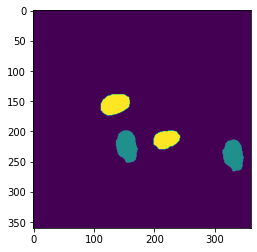

In [19]:
plt.imshow(Image.open("output/simple/forgery/duplication/copy-move/random/00493/overseg_figure_forgery_detection_map.png"))

In [15]:
from datetime import datetime
# Save CSV file
SIMPLE_EVAL.to_csv(f'simple_eval_{datetime.now().strftime("20%y-%m-%d-%H-%M")}.csv')

In [ ]:
SIMPLE_EVAL.sort_values(by=['F1']).iloc[-50:]

In [32]:
SIMPLE_EVAL = SIMPLE_EVAL.reset_index()

In [1]:
from glob import glob
import cv2
import numpy as np
from prettytable import PrettyTable
import os 
from metrics import (F1, precision, F1_CTP, precision_CTP)
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
import pandas as pd

In [2]:
SIMPLE_EVAL = pd.read_csv("simple_eval_2022-02-24-07-47.csv")

In [3]:
SIMPLE_EVAL['MODALITY'] = None

for index, row in SIMPLE_EVAL.iterrows():
    modality = row['Detection-Map']
    modality = "/".join(modality.split("/")[1:-2])
    SIMPLE_EVAL.loc[index, 'MODALITY'] = modality
    

In [7]:
###  Modality - F1 Score (No consistent Check)
x = PrettyTable()
x.field_names = ["Modality - F1 Score", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']
    
for g in SIMPLE_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means_f1 = {}
    for method, result in modality[['F1', 'Method']].groupby("Method"):
         means[method] = "%0.2f"%(np.round(result.mean()[0]*100, 2))
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']] )
            
print(x)
print("="*130)
print("-"*130)
print("="*130)

###  Modality - F1 Score CTP (WITH consistent Check)
x = PrettyTable()
x.field_names = ["Modality - F1 - Score with Check", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']
    
for g in SIMPLE_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means = {}
    for method, result in modality[['F1-Check', 'Method']].groupby("Method"):
         means[method] = "%0.2f"%(np.round(result.mean()[0]*100, 2))
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']] )
            
print(x)
print("="*130)
print("-"*130)
print("="*130)

###  Modality - Precision Score (No consistent Check)
x = PrettyTable()
x.field_names = ["Modality - Precision", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']
    
for g in SIMPLE_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means = {}
    for method, result in modality[['Precision', 'Method']].groupby("Method"):
         means[method] = "%0.2f"%(np.round(result.mean()[0]*100, 2))
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']] )
            
print(x)
print("="*130)
print("-"*130)
print("="*130)


###  Modality - Precision Score (With consistent Check)
x = PrettyTable()
x.field_names = ["Modality - Precision with Check", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']
    
for g in SIMPLE_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means = {}
    for method, result in modality[['Precision-Check', 'Method']].groupby("Method"):
         means[method] = "%0.2f"%(np.round(result.mean()[0]*100, 2))
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']] )
            
print(x)

+--------------------------------------------------+------------+---------+-----------+-----------+-----------+---------+------+
|               Modality - F1 Score                | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET | OVERSEG | HFPM |
+--------------------------------------------------+------------+---------+-----------+-----------+-----------+---------+------+
|            simple/forgery/cleaning/bf            |    0.00    |   0.94  |    0.00   |    0.00   |    3.55   |   0.26  | 0.00 |
|    simple/forgery/duplication/copy-move/flip     |    0.00    |   0.85  |    0.60   |    0.64   |    1.95   |   1.83  | 0.17 |
|   simple/forgery/duplication/copy-move/random    |    8.90    |  13.47  |    3.03   |    4.67   |   16.83   |  15.60  | 4.02 |
|  simple/forgery/duplication/copy-move/rotation   |    0.00    |   0.74  |    0.26   |    0.46   |    5.19   |   6.36  | 1.47 |
| simple/forgery/duplication/copy-move/translation |    1.14    |   4.98  |    0.25   |    0.55  

In [49]:

def format_output(means_f1, means_ctp):
    highest_f1 = max([float(val[1]) for val in means_f1.items()])
    highest_ctp = max([float(val[1]) for val in means_ctp.items()])
    
    output_string = ""
    for m in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'OVERSEG', 'HFPM', 'BUSTERNET']:
        res_f1 = float(means_f1[m])
        
        if res_f1 == highest_f1:
            res_f1 = "& \\textbf{\\num{%.2f}} "%res_f1
        else:
             res_f1 = "& \\num{%.2f}"%res_f1
        output_string = output_string + f" {res_f1}"
        
        res_ctp = float(means_ctp[m])
        
        if res_ctp == highest_ctp:
            res_ctp = "& \\textbf{\\num{%.2f}}"%res_ctp
        else:
             res_ctp = "& \\num{%.2f} "%res_ctp
                
        output_string =   output_string + f" {res_ctp}"
        
    return output_string

In [25]:
means_f1

{'BUSTERNET': '9.72',
 'HFPM': '2.40',
 'OVERSEG': '6.15',
 'SIFT-PM': '4.98',
 'SIFT-VOLE': '0.55',
 'SURF-VOLE': '0.25',
 'ZERNIKE-PM': '1.14'}

In [59]:
for g in SIMPLE_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    print(modality_name)

simple/forgery/cleaning/bf
simple/forgery/duplication/copy-move/flip
simple/forgery/duplication/copy-move/random
simple/forgery/duplication/copy-move/rotation
simple/forgery/duplication/copy-move/translation


In [63]:
###  Modality - F1 Score
tp_results = pd.DataFrame()
ctp_results = pd.DataFrame()


map_methods = {'simple/forgery/cleaning/bf': 'Cleaning with Brute-Force',
               'simple/forgery/duplication/copy-move/flip': 'Copy-Move (Flip)',
               'simple/forgery/duplication/copy-move/random': 'Copy-Move (Random)',
               'simple/forgery/duplication/copy-move/rotation': 'Copy-Move (Rotation)',
               'simple/forgery/duplication/copy-move/translation' :'Copy-move (Translation)'
              }
average_f1 = {m:0 for m in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'OVERSEG', 'HFPM', 'BUSTERNET']}
average_ctp = {m:0 for m in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'OVERSEG', 'HFPM', 'BUSTERNET']}

index= -1
for g in SIMPLE_EVAL.groupby('MODALITY'):
    index+=1
    modality_name = g[0]
    modality = g[1].drop(columns=["index"])
    means_f1 = {}
    means_ctp = {}
    
    print(modality_name.upper())
    # TP results
    for method, result in modality[['F1', 'Method']].groupby("Method"):
        means_f1[method] = "%0.2f"%(np.round(result.mean()[0]*100, 2))
        average_f1[method] += np.round(result.mean()[0]*100, 2)
        tp_results.loc[method,map_methods[modality_name]] = np.round(result.mean()[0]*100, 2)
        
        
    # CTP results
    for method, result in modality[['F1-Check', 'Method']].groupby("Method"):
        means_ctp[method] = "%0.2f"%(np.round(result.mean()[0]*100, 2))
        average_ctp[method] += result.mean()[0]*100
        ctp_results.loc[method,map_methods[modality_name]] = np.round(result.mean()[0]*100, 2)
    
    print(format_output(means_f1, means_ctp), '\\\\ \\hline')
    print("========"*10)

for method, result in modality[['F1-Check', 'Method']].groupby("Method"):
    average_f1[method] = np.round(average_f1[method]/ len(SIMPLE_EVAL.groupby('MODALITY')), 2)
    average_ctp[method] = np.round(average_ctp[method]/ len(SIMPLE_EVAL.groupby('MODALITY')), 2)
    
print("AVERAGE")
print(format_output(average_f1, average_ctp), '\\\\ \\hline')
print("========"*10)

SIMPLE/FORGERY/CLEANING/BF
 & \num{0.00} & \num{0.00}  & \num{0.94} & \num{0.08}  & \num{0.00} & \num{0.00}  & \num{0.00} & \num{0.00}  & \num{0.26} & \num{0.04}  & \num{0.00} & \num{0.00}  & \textbf{\num{3.55}}  & \textbf{\num{2.59}} \\ \hline
SIMPLE/FORGERY/DUPLICATION/COPY-MOVE/FLIP
 & \num{0.00} & \num{0.00}  & \num{0.85} & \num{0.55}  & \num{0.60} & \num{0.59}  & \num{0.64} & \num{0.54}  & \num{1.83} & \num{0.99}  & \num{0.17} & \num{0.14}  & \textbf{\num{1.95}}  & \textbf{\num{1.19}} \\ \hline
SIMPLE/FORGERY/DUPLICATION/COPY-MOVE/RANDOM
 & \num{8.90} & \num{8.82}  & \num{13.47} & \num{12.51}  & \num{3.03} & \num{3.03}  & \num{4.67} & \num{4.66}  & \num{15.60} & \num{13.31}  & \num{4.02} & \num{3.50}  & \textbf{\num{16.83}}  & \textbf{\num{16.04}} \\ \hline
SIMPLE/FORGERY/DUPLICATION/COPY-MOVE/ROTATION
 & \num{0.00} & \num{0.00}  & \num{0.74} & \num{0.39}  & \num{0.26} & \num{0.26}  & \num{0.46} & \num{0.46}  & \textbf{\num{6.36}}  & \textbf{\num{5.24}} & \num{1.47} & \num{1.42}  

In [67]:
tp_results.to_csv("SIMPLE_F1_TP.csv")
ctp_results.to_csv("SIMPLE_F1_CTP.csv")


In [56]:
###  Modality - Precision Score
average_f1 = {m:0 for m in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'OVERSEG', 'HFPM', 'BUSTERNET']}
average_ctp = {m:0 for m in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'OVERSEG', 'HFPM', 'BUSTERNET']}

for g in SIMPLE_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    modality = g[1].drop(columns=["index"])
    means_f1 = {}
    means_ctp = {}
    print(modality_name.upper())
    for method, result in modality[['Precision', 'Method']].groupby("Method"):
        means_f1[method] = "%0.2f"%(np.round(result.mean()[0]*100, 2))
        average_f1[method] += np.round(result.mean()[0]*100, 2)
    for method, result in modality[['Precision-Check', 'Method']].groupby("Method"):
        means_ctp[method] = "%0.2f"%(np.round(result.mean()[0]*100, 2))
        average_ctp[method] += result.mean()[0]*100
    
    print(format_output(means_f1, means_ctp), '\\\\ \\hline')
    print("========"*10)

for method, result in modality[['F1-Check', 'Method']].groupby("Method"):
    average_f1[method] = np.round(average_f1[method]/ len(SIMPLE_EVAL.groupby('MODALITY')), 2)
    average_ctp[method] = np.round(average_ctp[method]/ len(SIMPLE_EVAL.groupby('MODALITY')), 2)
    
print("AVERAGE")
print(format_output(average_f1, average_ctp), '\\\\ \\hline')
print("========"*10)

SIMPLE/FORGERY/CLEANING/BF
 & \num{0.00} & \num{0.00}  & \num{1.06} & \num{0.09}  & \num{0.00} & \num{0.00}  & \num{0.00} & \num{0.00}  & \num{0.42} & \num{0.07}  & \num{0.00} & \num{0.00}  & \textbf{\num{15.83}}  & \textbf{\num{8.71}} \\ \hline
SIMPLE/FORGERY/DUPLICATION/COPY-MOVE/FLIP
 & \num{0.00} & \num{0.00}  & \num{1.13} & \num{0.77}  & \num{0.96} & \num{0.94}  & \num{1.04} & \num{0.87}  & \num{3.78} & \num{2.15}  & \num{0.12} & \num{0.10}  & \textbf{\num{17.28}}  & \textbf{\num{5.94}} \\ \hline
SIMPLE/FORGERY/DUPLICATION/COPY-MOVE/RANDOM
 & \num{12.33} & \num{12.25}  & \num{14.55} & \num{13.52}  & \num{5.63} & \num{5.63}  & \num{10.24} & \num{10.20}  & \num{25.68} & \num{22.36}  & \num{3.86} & \num{3.40}  & \textbf{\num{58.61}}  & \textbf{\num{46.56}} \\ \hline
SIMPLE/FORGERY/DUPLICATION/COPY-MOVE/ROTATION
 & \num{0.00} & \num{0.00}  & \num{0.82} & \num{0.38}  & \num{0.34} & \num{0.34}  & \num{0.68} & \num{0.68}  & \num{10.81} & \textbf{\num{8.87}} & \num{1.27} & \num{1.23}  & \

output_string

In [23]:
print(x.get_csv_string(delimiter='\t'))

Modality - Precision with Check	ZERNIKE-PM	SIFT-PM	SURF-VOLE	SIFT-VOLE	BUSTERNET
simple/forgery/cleaning/bf	0.00000	0.00123	0.00000	0.00000	0.08711
simple/forgery/duplication/copy-move/flip	0.00000	0.00673	0.00768	0.00752	0.05939
simple/forgery/duplication/copy-move/random	0.12031	0.12244	0.05616	0.10193	0.46559
simple/forgery/duplication/copy-move/rotation	0.00000	0.00359	0.00331	0.00597	0.06919
simple/forgery/duplication/copy-move/translation	0.01919	0.03726	0.00375	0.00688	0.17123

